In [1]:
# Import everything needed to edit/save/watch video clips
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()


In [2]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


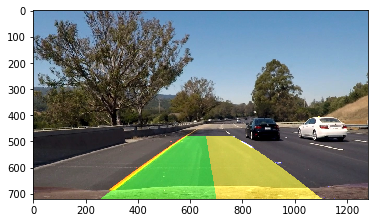

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from matplotlib.path import Path


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    

    a = np.array(left_fitx)
    b = np.array(ploty)
    arr1 = np.dstack((a,b))
    c = np.array(right_fitx)
    arr2 = np.dstack((c,b))
    
    arrRight = np.concatenate(([[700,0]], arr2[0], [[700,720]]), axis=0)
    arrLeft = np.concatenate(([[700,0]], arr1[0], [[700,720]]), axis=0)
    
    ptsRight = np.array(arrRight, np.int32)
    ptsLeft = np.array(arrLeft, np.int32)
    cv2.fillConvexPoly(out_img, ptsRight,(255,255,0))
    cv2.fillConvexPoly(out_img, ptsLeft,(0,255,0))
    return out_img

def process_image(image):
    
    # Choose a Sobel kernel size
    ksize = 9 # Choose a larger odd number to smooth gradient measurements

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    g_channel = image[:,:,1]
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    #Threshold color channel G
    g_thresh_min = 170
    g_thresh_max = 255
    g_binary = np.zeros_like(g_channel)
    g_binary[(g_channel >= g_thresh_min) & (g_channel <= g_thresh_max)] = 1
    

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    #Applying mask if needed
    mask = np.zeros_like(combined_binary)
    ignore_mask_color = 255  

    imshape = image.shape

    left_border = imshape[1] * 0.2
    right_border = imshape[1]
    top_border = imshape[0]/1.5
    left_top = left_border * 2
    right_top = imshape[1] - left_top


    vertices = np.array([[
        (left_border,imshape[0]),
        (left_top, top_border),
        (right_top, top_border),
        (right_border,imshape[0])
    ]], dtype=np.int32)

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_edges = cv2.bitwise_and(combined_binary, mask)
    
    
    
    img_size = (image.shape[1], image.shape[0])


    left_border = img_size[0] * 0.2
    right_border = img_size[0] - left_border
    top_border = img_size[1] / 1.5
    left_top = left_border*2
    right_top = img_size[0] - left_top




    src = np.float32([
        [left_border,img_size[1]],
        [left_top, top_border],
        [right_top, top_border],
        [right_border,img_size[1]]
    ])


    dst = np.float32([
        [left_border,img_size[1]],
        [left_border,0],
        [right_border,0],
        [right_border,img_size[1]]
    ])



    M = cv2.getPerspectiveTransform(src,dst)
    
    M_return = cv2.getPerspectiveTransform(dst,src)

    warped = cv2.warpPerspective(masked_edges, M, img_size, flags=cv2.INTER_LINEAR)
    
    itog = fit_polynomial(warped)
    
    returned = cv2.warpPerspective(itog, M_return, img_size, flags=cv2.INTER_LINEAR)
    
    final = cv2.addWeighted(returned, 0.5, image, 1, 0)
    
    return final

fname = 'test_images/test6.jpg'
img = cv2.imread(fname)
converted = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
dstimg = cv2.undistort(converted, mtx, dist, None, mtx)
out_img = process_image(converted)
plt.imshow(out_img)


# white_output = 'test_videos_output/project_video.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)





In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
  
</video>
""".format(white_output))